In [100]:
import torch
import pandas as pd
import cheetah
import torch.nn as nn
from gpytorch.constraints.constraints import Positive
from gpytorch.means import Mean
from gpytorch.priors import SmoothedBoxPrior

import xopt
from xopt.generators.bayesian import UpperConfidenceBoundGenerator
from xopt.generators.bayesian.models.standard import StandardModelConstructor
import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

## Using the Cheetah Model as an Infomative Prior for Bayesian Optimization

In this tutorial, we will use Cheetah to make Bayesian otpimization more efficient for an accelerator optimization problem.

### Interlude: Bayesian Optimization (BO)



<img src="fig/bo_steps.png" width=400>

For more details on BO, c.f. [R. Roussel et al. PRAB 2024](https://journals.aps.org/prab/abstract/10.1103/PhysRevAccelBeams.27.084801)

### Prior-Mean Assisting Gaussian Process (GP) Model

In BO, one often assumes a zero-mean prior for the GP model, i.e. the objective function is completely unknown.

The BO process can become more efficient if we can provide informative prior to the GP model.

In the context of particle acceleraotrs, the prior mean functions can for example be 

- Analytic functions
- Neural networks trained on experimental data
- Physics simulations

Cheetah's **speed** and **differentiability** make it feasible to be directly used as a prior-mean function in GP without drastically slowing down the BO inference.

### Example Case: A Simple FODO Lattice

First, we construct a simple FODO lattic in Cheetah.

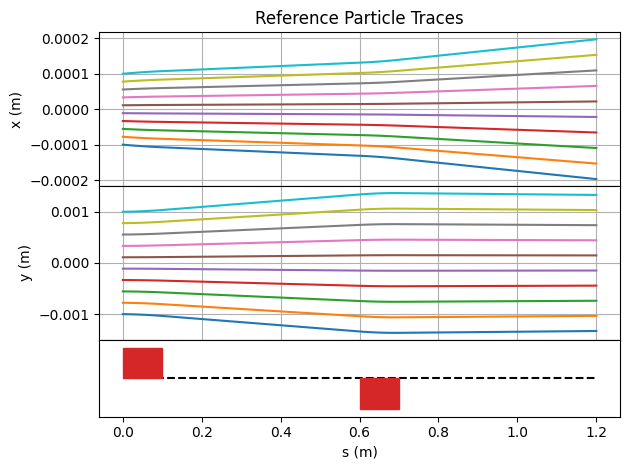

In [101]:
fodo_segment = cheetah.Segment(
        [
            cheetah.Quadrupole(
                length=torch.tensor(0.1), k1=torch.tensor(5.0), name="Q1"
            ),
            cheetah.Drift(length=torch.tensor(0.5), name="D1"),
            cheetah.Quadrupole(
                length=torch.tensor(0.1), k1=torch.tensor(-5.0), name="Q2"
            ),
            cheetah.Drift(length=torch.tensor(0.5), name="D2"),
        ]
    )
incoming_beam = cheetah.ParameterBeam.from_parameters(
            sigma_x=torch.tensor(1e-4),
            sigma_y=torch.tensor(1e-3),
            sigma_px=torch.tensor(1e-4),
            sigma_py=torch.tensor(1e-4),
            energy=torch.tensor(100e6),
        )
fodo_segment.plot_overview(incoming_beam)

Let's wrap it into a function for Xopt.

The function takes the quadrupole strengths as a dictionary 
```python
input_param={"q1": q1, "q2": q2}
``` 
It tracks the beam and returns the mean absolute error (MAE) of the beam sizes $\sigma_{x,y}$ at the end of the FODO segment. 

The goal is then to minimize the `mae` by varying the quadrupoles `[q1,q2]`.

In [ ]:
def simple_fodo_problem(
    input_param: dict[str, float],
    incoming_beam: cheetah.Beam | None = None,
    lattice_distances: dict[str, float] = {},
) -> dict[str, float]:
    if incoming_beam is None:
        incoming_beam = cheetah.ParameterBeam.from_parameters(
            sigma_x=torch.tensor(1e-4),
            sigma_y=torch.tensor(2e-3),
            sigma_px=torch.tensor(1e-4),
            sigma_py=torch.tensor(1e-4),
            energy=torch.tensor(100e6),
        )
    quad_length = torch.tensor(lattice_distances.get("quad_length", 0.1))
    drift_length = torch.tensor(lattice_distances.get("drift_length", 0.5))

    fodo_segment = cheetah.Segment(
        [
            cheetah.Quadrupole(
                length=quad_length, k1=torch.tensor(input_param["q1"]), name="Q1"
            ),
            cheetah.Drift(length=drift_length, name="D1"),
            cheetah.Quadrupole(
                length=quad_length, k1=torch.tensor(input_param["q2"]), name="Q2"
            ),
            cheetah.Drift(length=drift_length, name="D1"),
        ]
    )

    out_beam = fodo_segment(incoming_beam)

    beam_size_mae = 0.5 * (out_beam.sigma_x.abs() + out_beam.sigma_y.abs())

    return {
        "mae": beam_size_mae.detach().numpy(),
    }

Set the optimization bounds

In [103]:
vocs_config = """
        variables:
            q1: [-30, 15]
            q2: [-15, 30]
        objectives:
            mae: minimize
    """
vocs = xopt.VOCS.from_yaml(vocs_config)

incoming_beam = cheetah.ParameterBeam.from_parameters(
    sigma_x=torch.tensor(1e-3),
    sigma_y=torch.tensor(1e-3),
    sigma_px=torch.tensor(1e-4),
    sigma_py=torch.tensor(1e-4),
    energy=torch.tensor(100e6),
)
evaluator = xopt.Evaluator(
    function=simple_fodo_problem,
    function_kwargs={
        "incoming_beam": incoming_beam,
        "lattice_distances": {"drift_length": 0.7},
    },
)

### Use the basic BO to optimize the problem

In [104]:
N_TRIALS = 5 # Run the evluation multiple times to get some statistics
N_STEPS = 30 # How many optimization steps to run for each trial

In [105]:
df_bo_ucb = pd.DataFrame()
for i in range(N_TRIALS):
    generator = UpperConfidenceBoundGenerator(beta=2.0, vocs=vocs)
    x = xopt.Xopt(
            vocs=vocs,
            evaluator=evaluator,
            generator=generator,
            max_evaluations=N_STEPS,
        )
    # Fixed starting point
    x.evaluate_data(
        {
            "q1": -20.0,
            "q2": 20.0,
        }
    )
    # Start Optimization
    for _ in tqdm.tqdm(range(N_STEPS)):
        x.step()

    # xopt.run()
    # Post processing the dataframes
    x.data.index.name = "step"
    x.data["run"] = i
    x.data["best_mae"] = x.data["mae"].cummin()
    for col in x.data.columns:
        x.data[col] = x.data[col].astype(float)
    df_bo_ucb = pd.concat([df_bo_ucb, x.data])

100%|██████████| 30/30 [00:02<00:00, 12.40it/s]


#### Look at the Results

(0.0, 30.0)

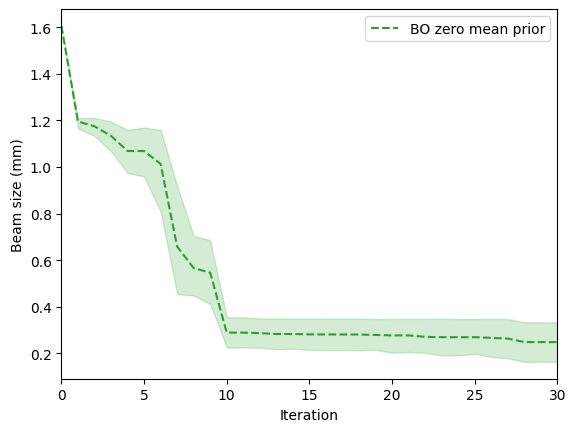

In [106]:
fig, ax = plt.subplots()
colors = sns.color_palette()
sns.lineplot(
    data=df_bo_ucb,
    x="step",
    y="best_mae",
    ax=ax,
    label="BO zero mean prior",
    color=colors[2],
    ls="--",
)
yticks = ax.get_yticks()[1:]
ax.set_yticks(np.arange(0.2, 1.8, 0.2) * 1e-3)
ax.set_yticklabels(
    np.arange(0.2, 1.8, 0.2).round(2)
)
ax.set_ylabel("Beam size (mm)")
ax.set_xlabel("Iteration")
ax.set_xlim(0, N_STEPS)
# ax.legend(ncol=2)

### Wrap the Cheetah Lattice as a Prior Mean Module for the GP Model

In [107]:
class FodoPriorMean(Mean):
    """FODO Lattice as a prior mean function for BO."""

    def __init__(self, incoming_beam: cheetah.Beam | None = None):
        super().__init__()
        if incoming_beam is None:
            incoming_beam = cheetah.ParameterBeam.from_parameters(
                sigma_x=torch.tensor(1e-4),
                sigma_y=torch.tensor(2e-3),
                sigma_px=torch.tensor(1e-4),
                sigma_py=torch.tensor(1e-4),
                energy=torch.tensor(100e6),
            )
        self.incoming_beam = incoming_beam
        self.Q1 = cheetah.Quadrupole(
            length=torch.tensor([0.1]), k1=torch.tensor([0.1]), name="Q1"
        )
        self.D1 = cheetah.Drift(length=torch.tensor([0.1]), name="D1")
        self.Q2 = cheetah.Quadrupole(
            length=torch.tensor([0.1]), k1=torch.tensor([0.1]), name="Q2"
        )
        self.D2 = cheetah.Drift(length=torch.tensor([0.1]), name="D2")
        self.segment = cheetah.Segment(elements=[self.Q1, self.D1, self.Q2, self.D2])

        # Introduce a fittable parameter for the lattice
        drift_length_constraint = Positive()
        self.register_parameter("raw_drift_length", nn.Parameter(torch.tensor(0.0)))
        self.register_prior(
            "drift_length_prior",
            SmoothedBoxPrior(0.2, 1.0),
            self._drift_length_param,
            self._set_drift_length,
        )
        self.register_constraint("raw_drift_length", drift_length_constraint)

    def forward(self, X: torch.Tensor) -> torch.Tensor:
        self.Q1.k1 = X[..., 0]

        self.Q2.k1 = X[..., 1]
        self.D1.length = self.drift_length
        self.D2.length = self.drift_length

        out_beam = self.segment(self.incoming_beam)
        beam_size_mae = 0.5 * (out_beam.sigma_x.abs() + out_beam.sigma_y.abs())
        return beam_size_mae

    @property
    def drift_length(self):
        return self._drift_length_param(self)

    @drift_length.setter
    def drift_length(self, value: torch.Tensor):
        self._set_drift_length(self, value)

    # Strange hack to conform with gpytorch definitions
    def _drift_length_param(self, m):
        return m.raw_drift_length_constraint.transform(self.raw_drift_length)

    def _set_drift_length(self, m, value: torch.Tensor):
        if not torch.is_tensor(value):
            value = torch.as_tensor(value).to(m.raw_drift_length)
        m.initialize(
            raw_drift_length=m.raw_drift_length_constraint.inverse_transform(value)
        )

#### Perform the optimization using Cheetah Prior Mean


In [108]:
df_bo_cheetah = pd.DataFrame()
for i in range(N_TRIALS):
    # Create a Cheetah Prior Mean and use it for GP Construction
    prior_mean_module = FodoPriorMean()
    prior_mean_module.drift_length = 0.4
    gp_constructor = StandardModelConstructor(
        mean_modules={"mae": prior_mean_module},
        trainable_mean_keys=["mae"],  # Allow the prior mean to be trained
    )
    generator = UpperConfidenceBoundGenerator(
        beta=2.0, vocs=vocs, gp_constructor=gp_constructor
    )

    x = xopt.Xopt(
            vocs=vocs,
            evaluator=evaluator,
            generator=generator,
            max_evaluations=N_STEPS,
        )
    # Fixed starting point
    x.evaluate_data(
        {
            "q1": -20.0,
            "q2": 20.0,
        }
    )
    # Start Optimization
    for _ in tqdm.tqdm(range(N_STEPS)):
        x.step()

    # xopt.run()
    # Post processing the dataframes
    x.data.index.name = "step"
    x.data["run"] = i
    x.data["best_mae"] = x.data["mae"].cummin()
    for col in x.data.columns:
        x.data[col] = x.data[col].astype(float)
    df_bo_cheetah = pd.concat([df_bo_cheetah, x.data])

100%|██████████| 30/30 [00:09<00:00,  3.29it/s]


#### Look at the comparison result


(0.0, 30.0)

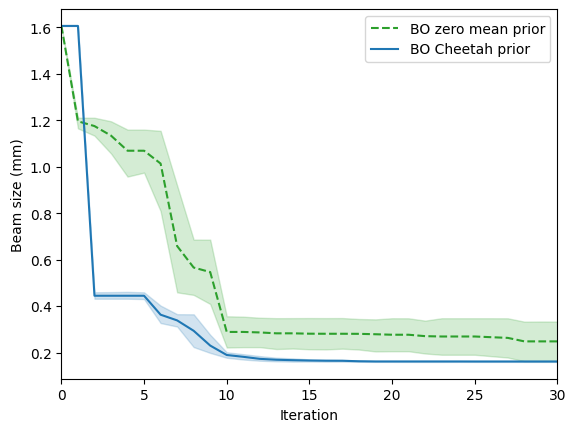

In [109]:
fig, ax = plt.subplots()
colors = sns.color_palette()
sns.lineplot(
    data=df_bo_ucb,
    x="step",
    y="best_mae",
    ax=ax,
    label="BO zero mean prior",
    color=colors[2],
    ls="--",
)
sns.lineplot(
    data=df_bo_cheetah,
    x="step",
    y="best_mae",
    ax=ax,
    label="BO Cheetah prior",
    color=colors[0],
    ls="-",
)
yticks = ax.get_yticks()[1:]
ax.set_yticks(np.arange(0.2, 1.8, 0.2) * 1e-3)
ax.set_yticklabels(
    np.arange(0.2, 1.8, 0.2).round(2)
)
ax.set_ylabel("Beam size (mm)")
ax.set_xlabel("Iteration")
ax.set_xlim(0, N_STEPS)


Note that the Cheetah model used as the prior mean is mismatched to the problem being optimized, with

- different incoming beam 
- different drift space lengths


In [116]:
q1 = np.linspace(vocs.variables["q1"][0], vocs.variables["q1"][1], 30, dtype=np.float32)
q2 = np.linspace(vocs.variables["q2"][0], vocs.variables["q2"][1], 50, dtype=np.float32)

X, Y = np.meshgrid(q1, q2)

Z_problem = np.zeros_like(X)
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        Z_problem[i, j] = simple_fodo_problem(
            {"q1": X[i, j], "q2": Y[i, j]}, incoming_beam, {"drift_length": 0.7}
        )["mae"]


In [117]:
prior_mean_module = FodoPriorMean()
prior_mean_module.drift_length = 0.4
Z_priormean = prior_mean_module(torch.tensor(np.array([X, Y]), dtype=torch.float32).T).detach().numpy().T

#### Visualizing the Mismatches in Models

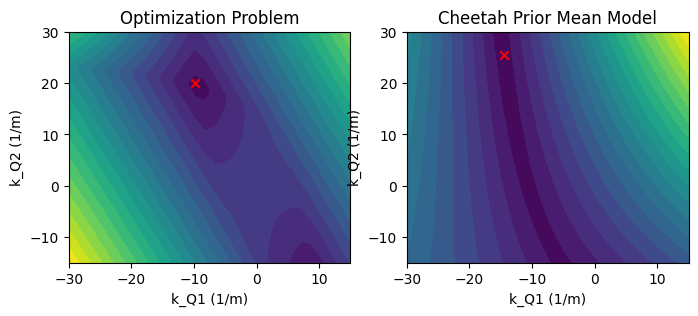

In [130]:
fig, axes = plt.subplots(1,2,figsize=(8,3))

axes[0].contourf(X, Y, Z_problem, levels=20)
axes[1].contourf(X, Y, Z_priormean, levels=20)
# Mark the minimum for both plots
idx_min_problem = np.unravel_index(np.argmin(Z_problem, axis=None), Z_problem.shape)
axes[0].scatter(q1[idx_min_problem[1]], q2[idx_min_problem[0]], color="red", marker="x")
idx_min_priormean = np.unravel_index(np.argmin(Z_priormean, axis=None), Z_priormean.shape)  
axes[1].scatter(q1[idx_min_priormean[1]], q2[idx_min_priormean[0]], color="red", marker="x")

axes[0].set_title("Optimization Problem") 
axes[1].set_title("Cheetah Prior Mean Model")

for ax in axes:
    ax.set_xlabel("k_Q1 (1/m)")
    ax.set_ylabel("k_Q2 (1/m)")

